# Customer Segmentation using RFM Analysis and KMeans Clustering

## 1. Problem Statement

The task involves identifying distinct customer groups from an online retail dataset. Each customer is characterized by three behavioral dimensions:

* **Recency (R):** Time since the last purchase.
* **Frequency (F):** Total number of purchases.
* **Monetary (M):** Total amount spent.

These three dimensions together form the **RFM framework**, widely used in marketing analytics to assess customer value. The goal is to segment customers into clusters such that businesses can apply **targeted marketing strategies** (e.g., loyalty programs for high-value customers, reactivation campaigns for dormant customers).

The key challenges are:

* Customer transaction data is **highly skewed** (a few customers spend disproportionately).
* Outliers and noise can distort clustering results.
* Choosing the **optimal number of clusters** requires careful evaluation.

---

## 2. Solution Approach

We implement **unsupervised clustering with KMeans** on the RFM dataset. The pipeline involves the following steps:

### Dataset Preparation

* Extract RFM features per customer from raw invoice data.
* Handle missing values and remove canceled/negative transactions.
* Remove extreme outliers (IQR-based filtering).
* Apply **log-transformation** to reduce skewness.
* Standardize features using **StandardScaler** for fair contribution.

### Model Selection

* Apply **KMeans clustering** on the scaled RFM dataset.
* Determine optimal cluster number using:

  * **Elbow Method** (distortion score).
  * **Silhouette Score** (cohesion vs. separation).
* Both methods suggested an optimal value of **k=3** clusters.

### Training Setup

* Train KMeans with **k=3 clusters** and `random_state=42`.
* Assign each customer to one of the clusters.

### Evaluation & Visualization

* **Boxplots** of R, F, and M across clusters to interpret customer profiles.
* **PCA-based 2D visualization** of clusters.
* **3D scatter plots (R, F, M)** for deeper insights.
* Cluster summary tables to highlight differences (e.g., average spend, recency).

---

## 3. Expected Outcomes

* Customers will be segmented into **three distinct groups**, for example:

  * **Cluster 2 (High-Value Customers):** Low recency, high frequency, high monetary.
  * **Cluster 0 (Moderate Customers):** Medium values across RFM.
  * **Cluster 1 (At-Risk Customers):** High recency, low frequency, low monetary.

* Visualizations will reveal:

  * Clear separation of customer behaviors.
  * Outlier handling ensures cluster quality.
  * Business can apply **different marketing strategies per cluster**.

This work demonstrates how **KMeans clustering combined with RFM analysis** can uncover actionable customer insights, guiding **customer retention, reactivation, and loyalty programs**.


In [ ]:
import pandas as pd
df= pd.read_excel('/content/Online Retail.xlsx')

In [ ]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.shape

(541909, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# **Data Cleaning**

In [ ]:
#Drop rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)
df.shape

(406829, 8)

In [ ]:
#Remove negative or zero Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()
df.shape

(397884, 8)

In [ ]:
df.loc[:, "InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
print(df.head())
print(df.tail())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
       InvoiceNo StockCode                      Description  Quantity  \
541904    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899     CHILDREN'S A

# **Feature Engineering**

In [ ]:
#From the columns, we can build RFM features:
#Recency: Days since last invoice date for each customer.
#Frequency: Count of invoices per customer.
#Monetary: Quantity × UnitPrice aggregated by customer.

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [ ]:
#Define a reference date (max InvoiceDate + 1 day)
#We need this to calculate Recency.

import datetime as dt

reference_date = df["InvoiceDate"].max() + dt.timedelta(days=1)

In [ ]:
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                    # Frequency
    "TotalPrice": "sum"                                        # Monetary
}).reset_index()


In [ ]:
rfm.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalPrice": "Monetary"
}, inplace=True)

print(rfm.head())


   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40


## **PREPROCESSING**

In [ ]:
#remove outliers
Q1 = rfm["Monetary"].quantile(0.25)
Q3 = rfm["Monetary"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower Bound:", lower_bound, "Upper Bound:", upper_bound)

rfm_no_outliers = rfm[(rfm["Monetary"] >= lower_bound) & (rfm["Monetary"] <= upper_bound)].copy()
print("Before:", rfm.shape[0], "After:", rfm_no_outliers.shape[0])

Lower Bound: -1724.0725000000004 Upper Bound: 3693.227500000001
Before: 4338 After: 3911


In [ ]:
'''
Monetary (and sometimes Frequency) is usually heavily right-skewed (a few customers spend a LOT).
We can smooth this with log-transform:
'''
import numpy as np
from sklearn.preprocessing import StandardScaler

# Log transform AFTER removing outliers
rfm_log = rfm_no_outliers.copy()
rfm_log["Recency"] = np.log1p(rfm_log["Recency"])
rfm_log["Frequency"] = np.log1p(rfm_log["Frequency"])
rfm_log["Monetary"] = np.log1p(rfm_log["Monetary"])

# Scale
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[["Recency", "Frequency", "Monetary"]])


KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=10), k=(1, 11))

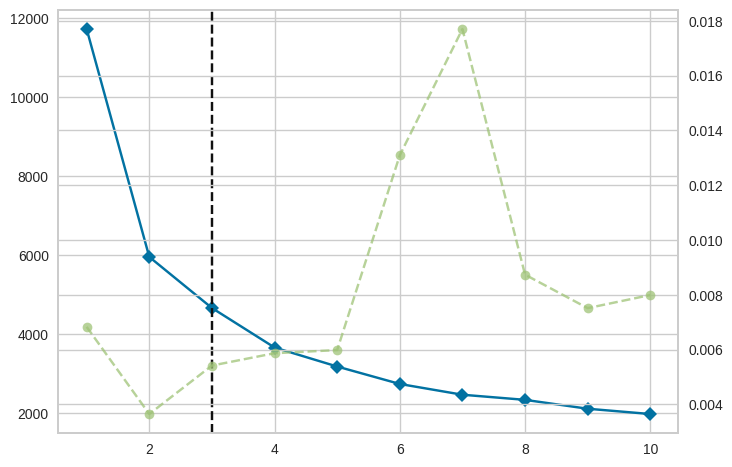

In [ ]:
#Use elbow method to find the k
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(rfm_scaled)

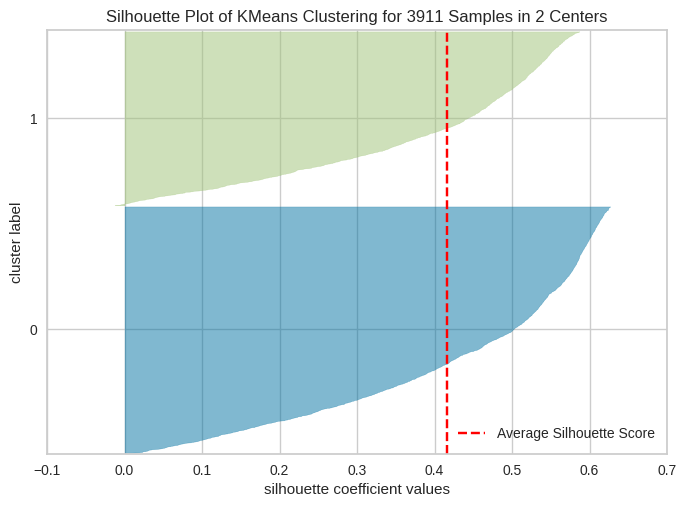

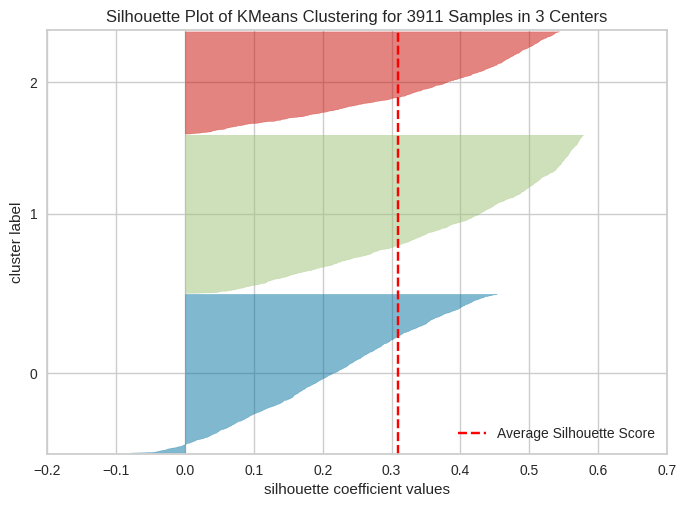

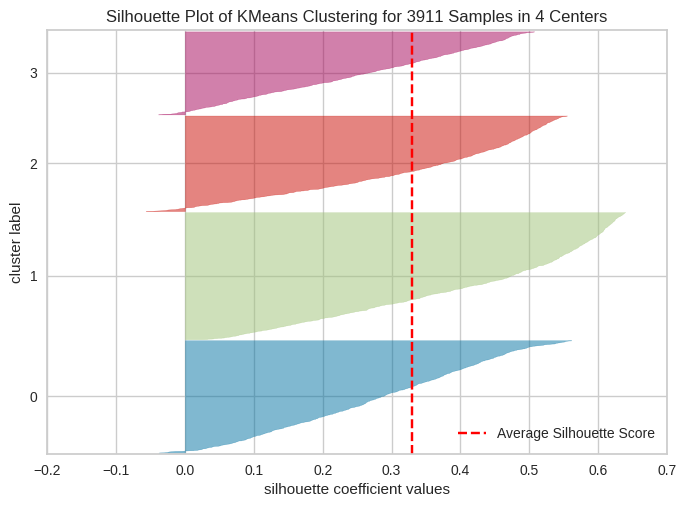

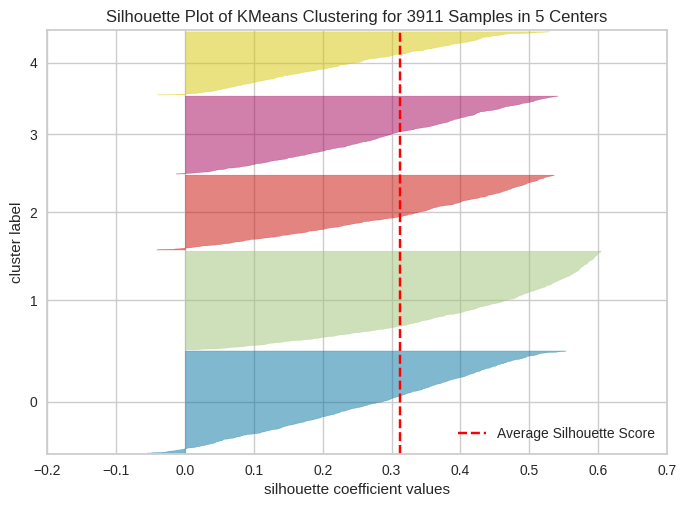

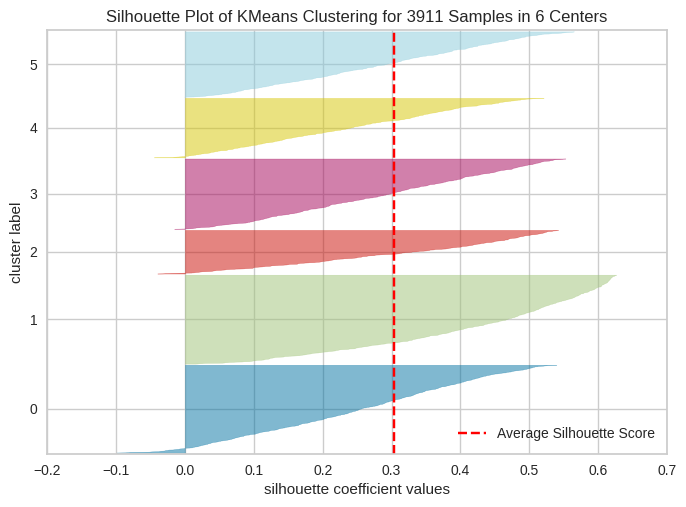

In [ ]:
#Use Silhouete method to find the optimum value of k
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

for k in range(2, 7):   # try a few values around what elbow suggested
    model = KMeans(n_clusters=k, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
    visualizer.fit(rfm_scaled)
    visualizer.show()



In [ ]:
#apply kmeans
from sklearn.cluster import KMeans

# Fit KMeans with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
rfm_no_outliers["Cluster"] = kmeans.fit_predict(rfm_scaled)

# Summary of clusters
cluster_summary = rfm_no_outliers.groupby("Cluster").mean()
print(cluster_summary)


           CustomerID     Recency  Frequency     Monetary
Cluster                                                  
0        15264.707827   71.713225   2.419028   844.869321
1        15427.939661  176.112542   1.187119   262.420672
2        15311.090147   25.794549   6.335430  1916.707621


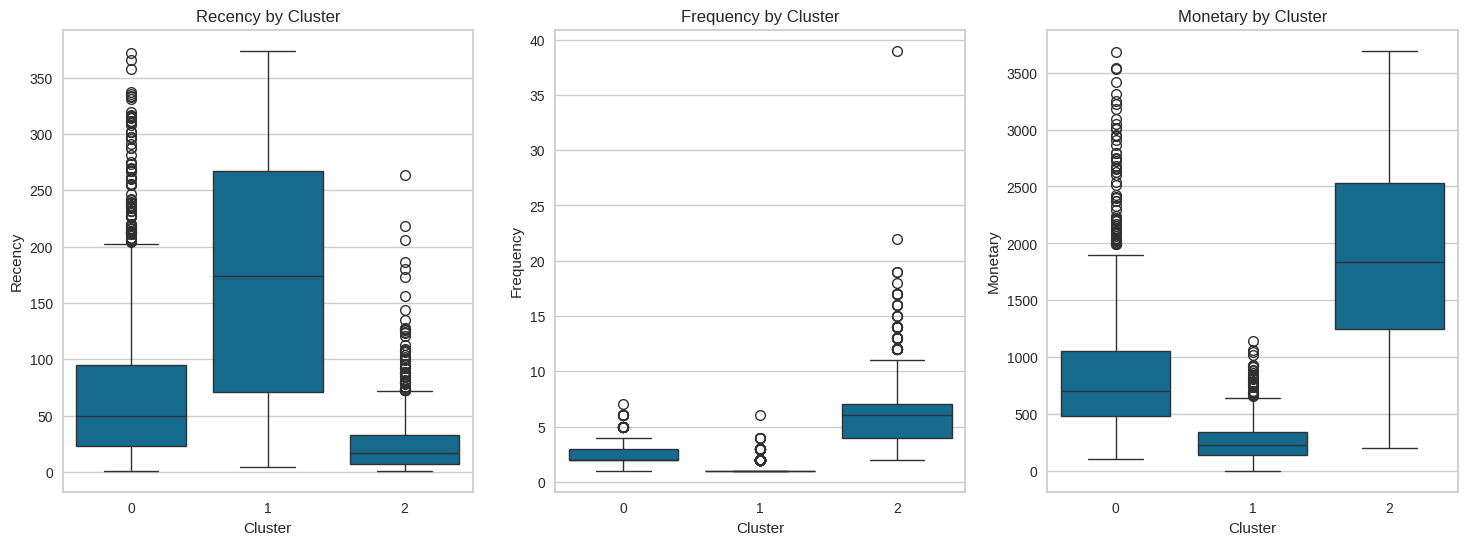

In [ ]:
#plot a boxplot using sns
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18,6))

# Recency
sns.boxplot(x="Cluster", y="Recency", data=rfm_no_outliers, ax=axes[0])
axes[0].set_title("Recency by Cluster")

# Frequency
sns.boxplot(x="Cluster", y="Frequency", data=rfm_no_outliers, ax=axes[1])
axes[1].set_title("Frequency by Cluster")

# Monetary
sns.boxplot(x="Cluster", y="Monetary", data=rfm_no_outliers, ax=axes[2])
axes[2].set_title("Monetary by Cluster")

plt.show()


### **Cluster-wise interpretation from your boxplots**

#### 1️⃣ Recency (lower = more recent, better customers)

* **Cluster 2** → lowest recency (median \~15–20 days) → **very recent buyers / loyal**.
* **Cluster 0** → moderate recency (\~40–60 days).
* **Cluster 1** → highest recency (median \~170+ days) → **inactive / lost customers**.

---

#### 2️⃣ Frequency (higher = more orders)

* **Cluster 2** → highest frequency (median \~5, with outliers up to 40). **They shop often**.
* **Cluster 0** → moderate frequency (\~2–3).
* **Cluster 1** → very low frequency (1–2 orders).

---

#### 3️⃣ Monetary (higher = more money spent)

* **Cluster 2** → by far the highest spending (median \~1800, some >3500). → **big spenders**.
* **Cluster 0** → medium spenders (\~700 median).
* **Cluster 1** → lowest spenders (\~250 median).

---

### **Profiles of each cluster**

* **Cluster 2 → VIP / Champions**

  * Recent buyers, buy frequently, and spend the most.
  * These are your **best customers** — nurture them (loyalty rewards, exclusives).

* **Cluster 0 → Regulars / Potential Loyalists**

  * Moderate recency, moderate frequency, medium spend.
  * Could be converted into VIPs with targeted campaigns.

* **Cluster 1 → At-risk / Lost**

  * High recency (haven’t bought in a long time), very low frequency, lowest spend.
  * These are **churned or inactive customers** — may need win-back campaigns.


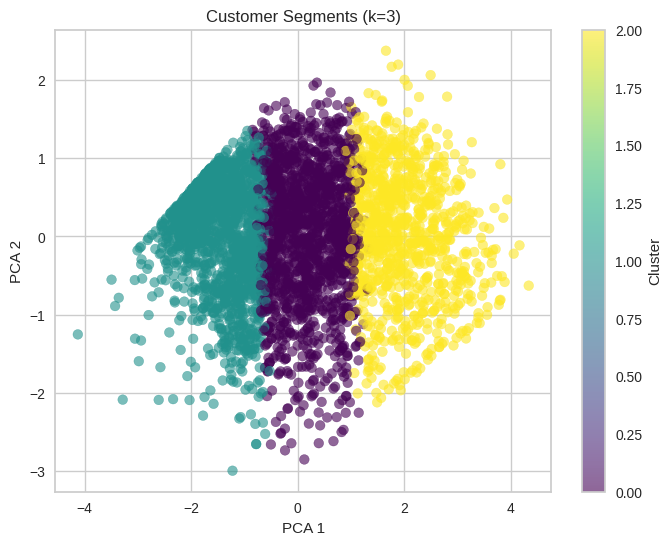

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
plt.scatter(rfm_pca[:,0], rfm_pca[:,1], c=rfm_no_outliers["Cluster"], cmap="viridis", alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Customer Segments (k=3)")
plt.colorbar(label="Cluster")
plt.show()


In [ ]:
import plotly.express as px

# 3D scatter plot for RFM clusters
fig = px.scatter_3d(
    rfm_no_outliers,
    x="Recency",
    y="Frequency",
    z="Monetary",
    color="Cluster",      # Cluster labels
    opacity=0.8,
    size_max=10
)

# Show plot
fig.show()
